# Diffraction Pattern Indexing with VAE

This notebook demonstrates how to use the `DiffractionPatternIndexer` to encode diffraction patterns into a latent space and retrieve their crystallographic orientations. The indexer uses a combination of:

1. A variational autoencoder (VAE) model to encode patterns into a latent representation
2. A vector database (ChromaDB) to efficiently store and retrieve latent vectors and their orientations

## Setup

First, let's load the necessary modules and configure auto-reloading for code changes.

In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import torch

from latice.index.dp_indexer import DiffractionPatternIndexer, IndexerConfig
from latice.index.chroma_db import (
    ChromaLatentVectorDatabaseConfig,
    ChromaLatentVectorDatabase,
)
from latice.model import VariationalAutoEncoderRawData

/Users/andrewtung/Documents/Github/latice


2025-04-27 00:01:18,859 - faiss.loader - INFO - Loading faiss.
2025-04-27 00:01:18,877 - faiss.loader - INFO - Successfully loaded faiss.
2025-04-27 00:01:18,880 - faiss - INFO - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.


## Initialise the Indexer

Now let's set up the indexer with the VAE model and a ChromaDB vector database. The indexer will automatically:
1. Load the diffraction patterns and orientation data
2. Encode the patterns into the latent space
3. Build a searchable database of latent vectors and their orientations

In [4]:
# Latent vector database config
collection_name = "test"
persist_directory = "notebook/.chroma_db_16d"
pattern_path = Path("data/N=100_noised.npy")
angles_path = Path("data/anglefile_N=100.txt")
dimension = 16
device = "mps"

# Indexer config
model_path = "checkpoints/vae-best.pt"
batch_size = 32
random_seed = 42
image_size = (128, 128)
top_n = 10
orientation_threshold = 3.0

In [5]:
# Initialise the vector database
db = ChromaLatentVectorDatabase(
    config=ChromaLatentVectorDatabaseConfig(
        collection_name=collection_name,
        persist_directory=persist_directory,
        dimension=dimension,
    )
)

# Initialise the VAE model
model = VariationalAutoEncoderRawData()
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# Initialise the indexer
indexer = DiffractionPatternIndexer(
    model=model,
    db=db,
    config=IndexerConfig(
        pattern_path=pattern_path,
        angles_path=angles_path,
        batch_size=batch_size,
        device=device,
        latent_dim=dimension,
        random_seed=random_seed,
        image_size=image_size,
        top_n=top_n,
        orientation_threshold=orientation_threshold,
    ),
)
# indexer.build_dictionary()

2025-04-27 00:01:31,827 - latice.index.chroma_db - INFO - Created persistent ChromaDB at notebook/.chroma_db_16d
2025-04-27 00:01:31,828 - latice.index.chroma_db - INFO - Retrieved existing collection 'test'
2025-04-27 00:01:31,904 - latice.index.dp_indexer - INFO - Using device: mps


## Explore the Data

Let's take a look at the diffraction patterns and their orientations:

In [ ]:
# Load a sample batch from the dataloader
dataloader = indexer._create_dataloader
sample_batch = next(iter(dataloader))
patterns, orientations = sample_batch

# Display the shape of the data
print(f"Patterns shape: {patterns.shape}")
print(f"Orientations shape: {orientations.shape}")

# Visualise a few patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(patterns[i].squeeze(), cmap="viridis")
    axes[i].set_title(f"Pattern {i}\nOrientation: {orientations[i].numpy()}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

## Indexing Single Patterns

Now let's index a single diffraction pattern and examine the results:

In [ ]:
# Load a sample pattern
# sample_pattern = np.load("../data/N=100_noised.npy")[50]
sample_pattern, angles = indexer._create_dataloader.dataset[0]
sample_pattern = sample_pattern.squeeze()

# Display the pattern
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
axs.imshow(sample_pattern, cmap="viridis")
axs.set_title("Sample Diffraction Pattern")
axs.axis("off")
plt.show()

# Time the indexing operation
start_time = time.time()
orientation_result = indexer.index_pattern(
    pattern=sample_pattern, top_n=20, orientation_threshold=3.0
)
end_time = time.time()

print(f"Indexed pattern in {end_time - start_time:.4f} seconds")
print(f"angles: {angles}")
print(f"Best orientation: {orientation_result.get_top_n_orientations(10)}")
print(f"Success: {orientation_result.success}")

## The Latent Space Representation

We can also examine the latent vector representation of a pattern:

In [6]:
import time
from rich.progress import (
    Progress,
    SpinnerColumn,
    TimeElapsedColumn,
    BarColumn,
    TextColumn,
)

batch_patterns_np = np.load(pattern_path)
num_rows = len(batch_patterns_np)
n_samples = 1000
random_indices = np.random.choice(num_rows, size=n_samples, replace=False)
sampled_arr = batch_patterns_np[random_indices]
all_index_times = []

with Progress(
    SpinnerColumn(),
    TextColumn("[progress.description]{task.description}"),
    BarColumn(),
    TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
    TimeElapsedColumn(),
) as progress:
    task = progress.add_task("[cyan]Indexing patterns...", total=n_samples)
    for i in random_indices:
        start_time = time.time()
        orientation_results_batch = indexer.index_pattern(
            batch_patterns_np[i], top_n=1, orientation_threshold=1.0
        )
        end_time = time.time()
        index_time = end_time - start_time
        all_index_times.append(index_time)
        progress.update(task, advance=1, time_elapsed=index_time)

mean_index_time = np.mean(all_index_times)
std_index_time = np.std(all_index_times)
print(f"Average time per pattern: {mean_index_time:.4f} seconds")
print(f"Standard deviation of time per pattern: {std_index_time:.4f} seconds")


Output()

Indexed 333227 patterns in 0.0146 seconds
Average time per pattern: 0.0154 seconds


In [7]:
mean_index_time = np.mean(all_index_times)
std_index_time = np.std(all_index_times)
print(f"Average time per pattern: {mean_index_time:.4f} seconds")
print(f"Standard deviation of time per pattern: {std_index_time:.4f} seconds")

Average time per pattern: 0.0154 seconds
Standard deviation of time per pattern: 0.0193 seconds


In [ ]:
# Encode the pattern to get its latent representation
latent_vector = indexer.encode_pattern(sample_pattern)
print(f"Latent vector dimension: {latent_vector.shape}")
print(f"Latent vector: {latent_vector}")

fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.bar(range(len(latent_vector)), latent_vector)
axs.set_xlabel("Dimension")
axs.set_ylabel("Value")
axs.set_title("Latent Vector Representation")
axs.grid(axis="y", alpha=0.3)
plt.show()

## Batch Processing

For efficiency, the indexer also supports batch processing of multiple patterns:

Output()

2025-04-26 23:13:23,579 - latice.index.chroma_db - WARNING - Failed to find best orientation after 3 iterations
2025-04-26 23:13:23,586 - latice.index.chroma_db - WARNING - Failed to find best orientation after 3 iterations


Indexed 5 patterns in 0.5372 seconds
Average time per pattern: 0.1074 seconds

Results summary:
Pattern 0: [ 148.3479042    30.41371855 -173.35637048] (success: True)
Pattern 1: [-123.61719815   39.40408647  161.80372175] (success: True)
Pattern 2: [-122.7485742    38.76634791  161.30816434] (success: True)
Pattern 3: None (success: False)
Pattern 4: None (success: False)


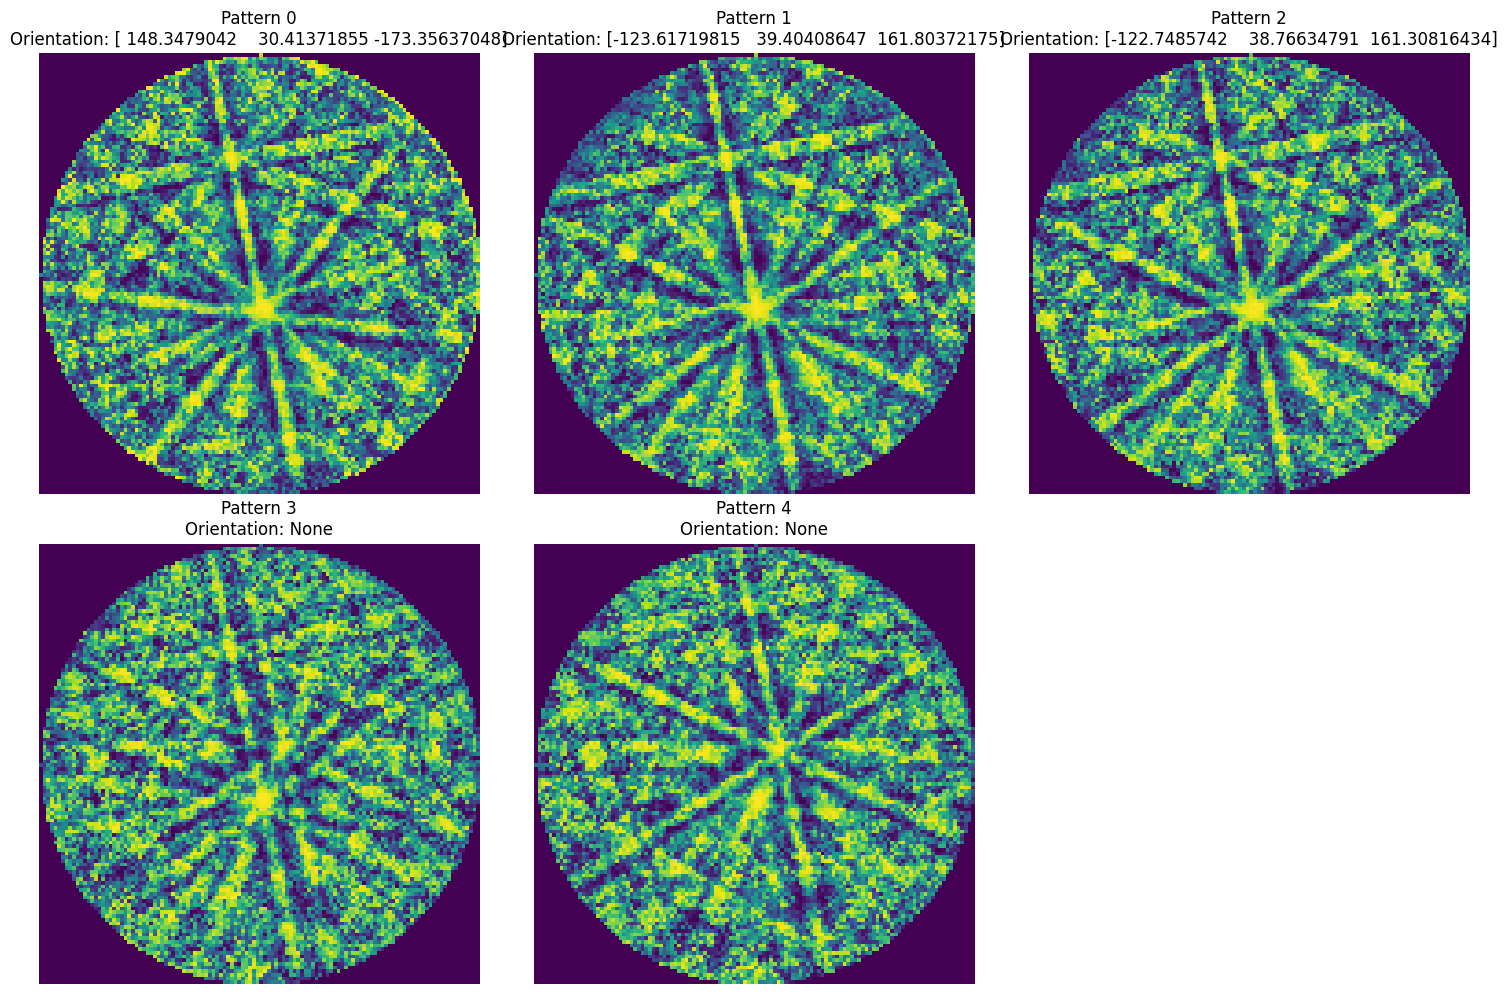

In [4]:
# Load multiple patterns
batch_patterns = np.load("../data/sample_pattern.npy")[:5]

# Time batch indexing
start_time = time.time()
orientation_results = indexer.index_patterns_batch(batch_patterns, top_n=1, orientation_threshold=3.0)
end_time = time.time()

print(f"Indexed {len(batch_patterns)} patterns in {end_time - start_time:.4f} seconds")
print(
    f"Average time per pattern: {(end_time - start_time) / len(batch_patterns):.4f} seconds"
)

print("\nResults summary:")
for i, result in enumerate(orientation_results):
    print(f"Pattern {i}: {result.mean_orientation} (success: {result.success})")

# Visualise the orientations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(5):
    axes[i].imshow(batch_patterns[i], cmap="viridis")
    axes[i].set_title(
        f"Pattern {i}\nOrientation: {orientation_results[i].mean_orientation}"
    )
    axes[i].axis("off")

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()